Mask R-CNN licence

Copyright (c) 2018 Matterport, Inc.

Licensed under the MIT License (see LICENSE for details)

Written by Waleed Abdulla

In [26]:
%tensorflow_version 1.x
!pip install keras==2.1.5

# **Clone and Install Mask_RCNN**

In [3]:
# clone Mask_RCNN repository
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [4]:
# installing Mask_RCNN
%cd Mask_RCNN
!python setup.py install

/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writin

In [5]:
# Check if mask_rcnn is installed or not
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


# **Clone The COCO Model**

In [ ]:
import os
import urllib.request
urllib.request.urlretrieve('https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5', 'mask_rcnn_coco.h5')


('mask_rcnn_coco.h5', <http.client.HTTPMessage at 0x7f0359a32590>)

# **Train The Model**

In [9]:
# define a configuration for the model
class GarbageConfig(Config):
    # define the name of the configuration
    NAME = "test"

    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 2
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131

    GPU_COUNT = 1

    IMAGES_PER_GPU = 1

    BATCH_SIZE = IMAGES_PER_GPU * GPU_COUNT

In [ ]:
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

class GarbageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):
        """Load a subset of the Garbage dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        self.add_class("garbage", 1, "shoe")
        self.add_class("garbage", 2, "papercup")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        annotations = json.load(open(os.path.join(annotations_dir, 'annotations.json')))
        annotations = list(annotations.values())  

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            names = [a['file_attributes']]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(images_dir , a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

			      # add to dataset
            self.add_image(
                'garbage',
                image_id=a['filename'],
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons,
                names=names)


    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a shoe or paper cup dataset image, delegate to parent class.
        image_info = self.image_info[image_id]

        # Convert polygons to a bitmap mask of shape
        info = self.image_info[image_id]
        class_names = info["names"]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Assign class_ids by reading class_names
        class_ids = np.zeros([len(info["polygons"])])

        for i, p in enumerate(class_names):
        #"class_name" is the attributes name decided when labeling, etc. 'file_attributes': {class_name:'shoe'}
            if p['class_name'] == 'shoe':
                class_ids[i] = 1
            elif p['class_name'] == 'paper cup':
                class_ids[i] = 2
            #assert code here to extend to other labels

        class_ids = class_ids.astype(int)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask, np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "garbage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


# train set
train_set = GarbageDataset()
train_set.load_dataset("/content/drive/MyDrive/dataset", "train")
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = GarbageDataset()
test_set.load_dataset("/content/drive/MyDrive/dataset", "val")
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = GarbageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')



Train: 181
Test: 40

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/5
130/131 [============================>.] - ETA: 1s - loss: 1.4779 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.6071 - mrcnn_mask_loss: 0.5177

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 231s 2s/step - loss: 1.4737 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.6043 - mrcnn_mask_loss: 0.5158 - val_loss: 0.9029 - val_rpn_class_loss: 0.0171 - val_rpn_bbox_loss: 0.2798 - val_mrcnn_class_loss: 0.0465 - val_mrcnn_bbox_loss: 0.3600 - val_mrcnn_mask_loss: 0.1995

Epoch 2/5
131/131 [==============================] - 183s 1s/step - loss: 0.7238 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.2220 - val_loss: 0.8362 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 0.2985 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.3095 - val_mrcnn_mask_loss: 0.1659
Epoch 3/5
131/131 [==============================] - 183s 1s/step - loss: 0.6036 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1950 - mrcnn_mask_loss: 0.1943 - val_loss: 0.7209 - val_rpn_class_loss: 0.0138 

"\n# plot first few images\nfor i in range(4):\n    # define subplot\n    pyplot.subplot(330 + 1 + i)\n    # plot raw pixel data\n    image = train_set.load_image(i)\n    pyplot.imshow(image)\n    print(train_set.image_reference(i))\n    #pyplot.title(train_set.image_reference(i))\n    # plot all masks\n    mask, _ = train_set.load_mask(i)\n    for j in range(mask.shape[2]):\n        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.5)\n# show the figure\npyplot.show()\n\n\n# load an image\nimage_id = 100\nimage = train_set.load_image(image_id)\nprint(image.shape)\n# load image mask\nmask, class_ids = train_set.load_mask(image_id)\nprint(mask.shape)\n# plot image\npyplot.imshow(image)\n# plot mask\npyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)\npyplot.show()\n\n"

# **Test The Model**


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

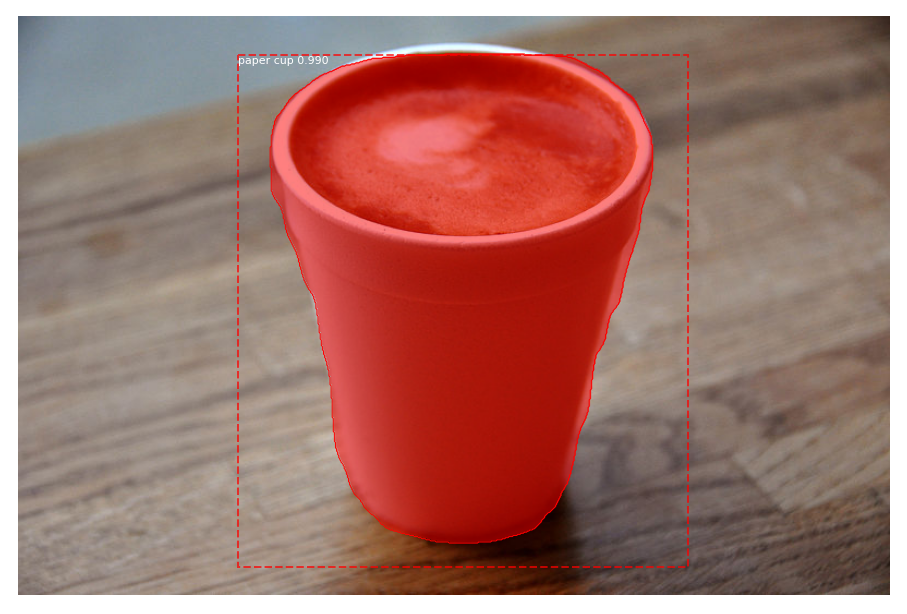

In [13]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# define 3 classes that the model knowns about
class_names = ['BG', 'shoe', 'paper cup']

# prepare config
config = GarbageConfig()
config.display()

# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=config)
# load coco model weights
rcnn.load_weights('/content/drive/MyDrive/dataset/mask_rcnn_garbage_0005.h5', by_name=True)
# load photograph
img = load_img('/content/drive/MyDrive/dataset/val/images/papercup13.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)

# get dictionary for first prediction
from mrcnn.visualize import display_instances
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


# **Test The Model Using Webcam**

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from time import sleep

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# webcam videos

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# define all the classes
class_names = ['BG', 'shoe', 'papercup']

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # get the predected results
    img = img_to_array(img)
    results = rcnn.detect([img], verbose=0)

    # get object region coordinates 
    dim_list = results[0]['rois'].tolist()
    # get objects class_ids
    class_ids_list = results[0]['class_ids'].tolist()
    
    # get object box for overlay and class_ids one by one
    for (x,y,w,h),i in zip(dim_list, class_ids_list):
        if(i != 2):
          cv2.putText(bbox_array, class_names[i], (y, x-10), 0, 0.5, (0,255,0), 2)
          bbox_array = cv2.rectangle(bbox_array,(y,x),(h,w),(0,255,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>